In [23]:
import numpy as np
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import glob
from config.config import *
from preprocessing.preprocessors import *
from analysis.analysis_functions import *
import re

In [24]:
os.chdir('C:\\Users\\Andy\\PycharmProjects\\finrlpaper1\\Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020\\')
cwd_ = os.getcwd() # get current working directory
cwd_

'C:\\Users\\Andy\\PycharmProjects\\finrlpaper1\\Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020'

### SETTINGS

In [47]:
class a_settings: # settings class only for analysis of results
    ### get all data saved from one run
    pass
class a_paths: 
    results_dir = "results"
    datapath = "data/preprocessed/done_data.csv"
    indexpath = "data/raw/DJI.csv"
    # path where analysis results are saved
    save_path = os.path.join("analysis", "results")
    file_extension = '.csv'

class a_temp:
    #run_of_choice = "04-10-2021_03-22-17_ppo__fm2"
    run_of_choice = "05-14-2021_02-11-32_ppo__fm6_st"
    strategy_mode = "ppo"
    sample = "test"
    n_seeds = 10

In [48]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Import preprocessed data & raw index data (DJIA 30)

In [49]:
data = load_dataset(file_path=a_paths.datapath,
                    col_subset=["datadate", "tic", "adjcp"])
data.head(3)

,datadate,tic,adjcp
0,20090102,AAPL,12.96
1,20090102,AXP,19.33
2,20090102,BA,45.25


In [50]:
dow30 = load_dataset(file_path=a_paths.indexpath,
                    col_subset=None) 
dow30.reset_index(inplace=True)
dow30.rename(columns={"Adj Close": "adjcp", "Date":"datadate"}, inplace=True)
dow30["datadate"] = pd.to_datetime(dow30["datadate"])
dow30 = dow30[["datadate", "adjcp"]]
dow30.head(3)

,datadate,adjcp
0,2009-01-02,9034.69
1,2009-01-05,8952.89
2,2009-01-06,9015.10


In [51]:
all_data_dict = {"data": data, "dow30": dow30}

In [52]:
data.datadate.dtype

dtype('int64')

In [53]:
dow30.datadate.dtype

dtype('<M8[ns]')

#### Get dates, tickers and episodes end iteration numbers

In [33]:
# get tickers
tickers = data.tic.unique()
print("tickers: ", tickers)
# get trades dates for validation
unique_trade_dates_validation = pd.read_csv(os.path.join(a_paths.results_dir,
                                                         "04-15-2021_23-12-43_ppo__fm3",
                                                         "unique_trade_dates_validation.csv"))#, index_col=0)
unique_trade_dates_validation = np.array(unique_trade_dates_validation)
print("\nvalidation dates: ")
unique_trade_dates_validation

tickers:  ['AAPL' 'AXP' 'BA' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GS' 'HD' 'IBM' 'INTC'
 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'RTX' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT' 'XOM']

validation dates: 


array([[20151002],
       [20151005],
       [20151006],
       ...,
       [20200702],
       [20200706],
       [20200707]], dtype=int64)

In [34]:
#unique_trade_dates_validation = data[(data.datadate > settings.STARTDATE_VALIDATION) &
#                                    (data.datadate <= settings.ENDDATE_VALIDATION)].datadate.unique()
#unique_trade_dates_validation

In [35]:
trade_start = unique_trade_dates_validation[126-63][0]
trade_end = unique_trade_dates_validation[1197][0]
print(f"trade start: {trade_start}, trade end: {trade_end}")

trade start: 20160104, trade end: 20200707


In [36]:
trade_dates = data[(data.datadate>=trade_start)&(data.datadate<=trade_end)].datadate.unique()
trade_dates

array([20160104, 20160105, 20160106, ..., 20200702, 20200706, 20200707],
      dtype=int64)

### get subset of data and dow30 based on trade dates

In [37]:
data_tradedates = data[(data.datadate>=trade_start)&(data.datadate<=trade_end)]
data_tradedates["datadate"] =  pd.to_datetime(data_tradedates["datadate"], format='%Y%m%d')
data_tradedates.set_index('datadate', inplace=True)
data_tradedates

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tic,adjcp
datadate,,
2016-01-04,AAPL,105.35
2016-01-04,AXP,67.59
2016-01-04,BA,140.50
2016-01-04,CAT,67.99
2016-01-04,CSCO,26.41
...,...,...
2020-07-07,V,194.20
2020-07-07,VZ,55.04
2020-07-07,WBA,42.22


In [38]:
dow30_tradedates = dow30[(dow30.datadate>="2016-01-04")&(dow30.datadate<="2020-07-07")]
#dow30_tradedates["datadate"] =  pd.to_datetime(dow30_tradedates["datadate"], format='%Y%m%d')
dow30_tradedates.set_index('datadate', inplace=True)
dow30_tradedates

,adjcp
datadate,
2016-01-04,17148.94
2016-01-05,17158.66
2016-01-06,16906.51
2016-01-07,16514.10
2016-01-08,16346.45
...,...
2020-06-30,25812.88
2020-07-01,25734.97
2020-07-02,25827.36


In [39]:
all_data_dict.update({"data_tradedates": data_tradedates, "dow30_tradedates": dow30_tradedates})

In [40]:
list(all_data_dict.keys())

['data', 'dow30', 'data_tradedates', 'dow30_tradedates']

### Policy vs. exercised policy

In [170]:
# get data from one run
# policy actions, exercised actions and number asset holdings
abspath = r"C:\Users\Andy\PycharmProjects\finrlpaper2\MT-DRL-Pytorch"
results_folder = "results"
run_folder = "06-05-2021_01-32-59_ppo__fm6_st"
seeds_list = ["agentSeed"+str(x) for x in settings.SEEDS_LIST]
results_of_interest = ["policy_actions", "exercised_actions", "number_asset_holdings"]

In [243]:
import glob

pol_act_dict = {}
exer_act_dict = {}
num_holdings_dict = {}

for i in seeds_list:
    pol_act_list = []
    exer_act_list = []
    num_holdings_list = []

    pol_act_glob = glob.glob(os.path.join(abspath, results_folder, run_folder, i, results_of_interest[0],
                                          'policy_actions_trade_ppo*.csv'))
    exer_act_glob = glob.glob(os.path.join(abspath, results_folder, run_folder, i, results_of_interest[1], 
                                           'exercised_actions_trade_ppo*.csv'))
    num_holdings_glob = glob.glob(os.path.join(abspath, results_folder, run_folder, i, results_of_interest[2], 
                                               'number_asset_holdings_trade_ppo*.csv'))
    
    for j1 in pol_act_glob:
        pol_act = pd.read_csv(j1, index_col=0)#.reset_index(drop=True)
        pol_act.columns = ["datadate"]+ticker_names
        pol_act_list.append(pol_act)#.reset_index(drop=True, inplace=True))                          
        
    for j2 in exer_act_glob:
        exer_act = pd.read_csv(j2, index_col=0).reset_index(drop=True)
        exer_act.columns = ["datadate"]+ticker_names
        exer_act_list.append(exer_act)                          

                                  
    for j3 in num_holdings_glob:
        num_holdings = pd.read_csv(j3, index_col=0).reset_index(drop=True)
        num_holdings.columns = ["datadate"]+ticker_names
        num_holdings_list.append(num_holdings)

    pol_act = pd.concat(pol_act_list)
    pol_act = pol_act.sort_values("datadate")
    pol_act = pol_act.drop_duplicates(subset=["datadate"], keep='last')
    
    exer_act = pd.concat(exer_act_list)
    exer_act = exer_act.sort_values("datadate")
    exer_act = exer_act.drop_duplicates(subset=["datadate"], keep='last')
    
    num_holdings = pd.concat(num_holdings_list)
    num_holdings = num_holdings.sort_values("datadate")
    num_holdings = num_holdings.drop_duplicates(subset=["datadate"], keep='last')

    pol_act_dict.update({i : pol_act})
    exer_act_dict.update({i : exer_act})
    num_holdings_dict.update({i: num_holdings})


### Policy Actions over multiple seeds
We see that if we look at e.g. AAPL (Apple) stock, the patterns of policy actions look very different.   
Sometimes there are similarities, but it looks rather spiky and noisy.

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


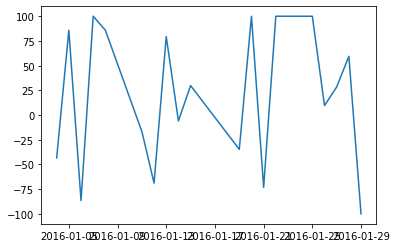

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


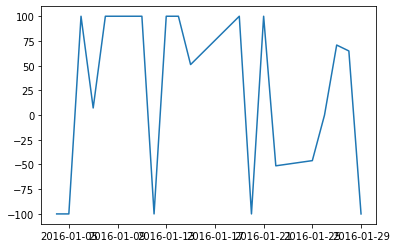

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


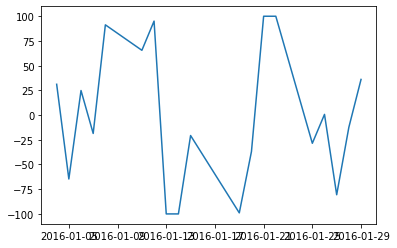

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


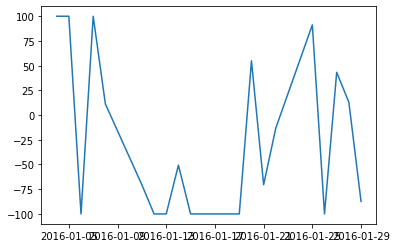

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


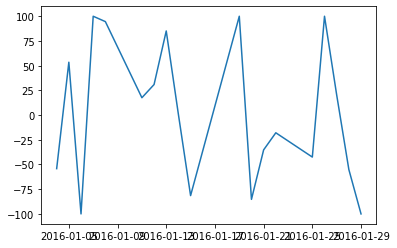

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


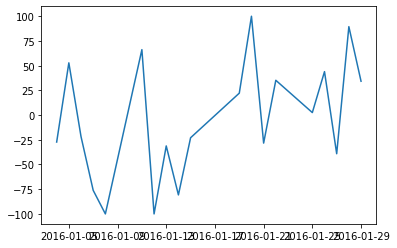

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


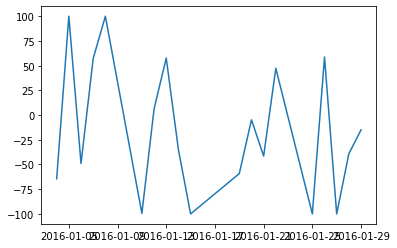

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


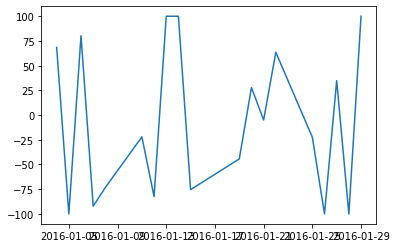

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


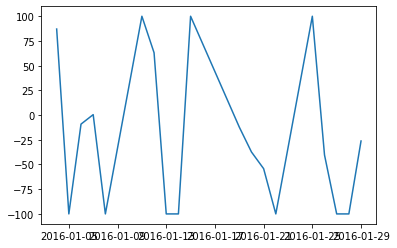

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


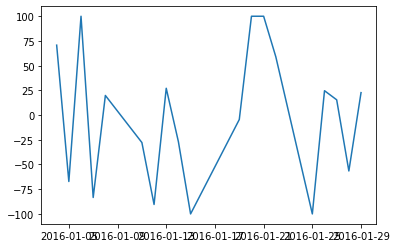

In [244]:
#pol_act_dict["agentSeed223445"]["datadate"]
for seed in seeds_list:
    df = pol_act_dict[seed][(pol_act_dict[seed]["datadate"]>=20160101)&
                                         (pol_act_dict[seed]["datadate"]<=20160130)]
    df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
    plt.plot(df["datadate"], df["AAPL"])
    plt.show()
    #df = pol_act_dict[seed][(pol_act_dict[seed]["datadate"]>=20160101)&(pol_act_dict[seed]["datadate"]<=20160301)]
    #plt.plot(df["datadate"], df["AAPL"])

### Exercised Actions over multiple seeds
As expected, the exercised actions are very similar to the policy actions, but there are slight differences.  
This is because the "optimal actions" given by the policy can sometimes not be exercised (e.g. budget limits, no short-selling, cannot buy fractions of a stock)


c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


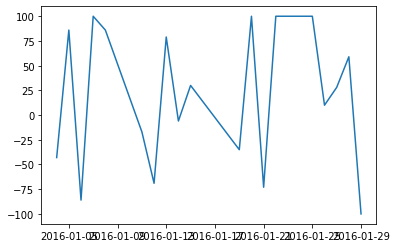

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


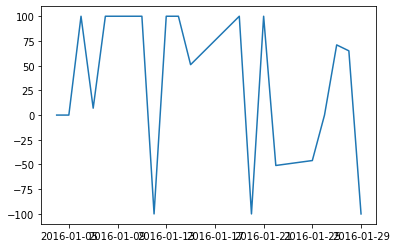

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


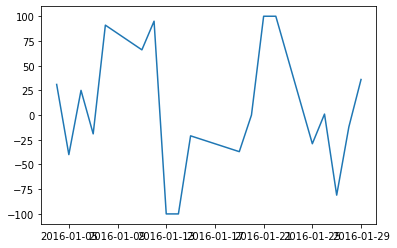

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


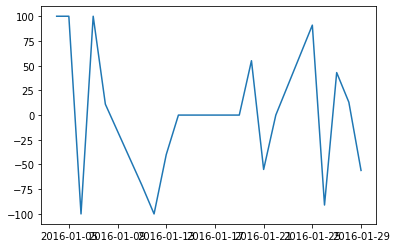

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


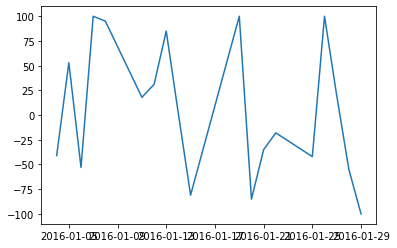

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


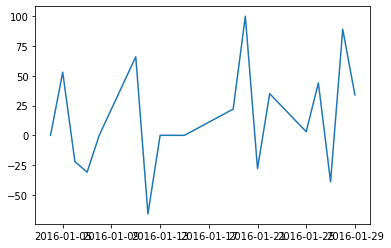

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


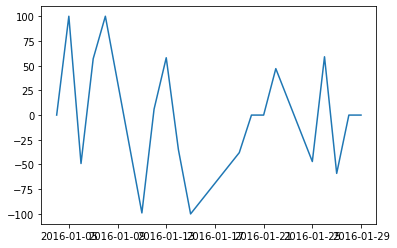

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


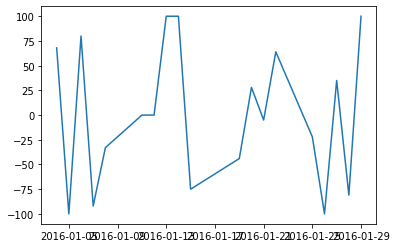

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


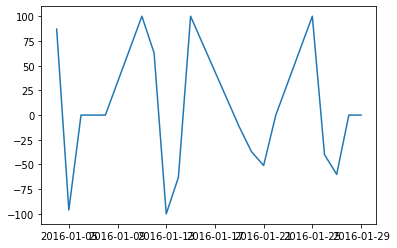

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


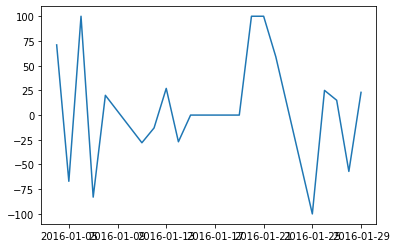

In [246]:
for seed in seeds_list:
    df = exer_act_dict[seed][(exer_act_dict[seed]["datadate"]>=20160101)&
                                         (exer_act_dict[seed]["datadate"]<=20160130)]
    df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
    plt.plot(df["datadate"], df["AAPL"])
    #print(seed)
    #plt.plot(exer_act_dict[seed]["datadate"], exer_act_dict[seed][ticker_names])
    plt.show()

### Comparison Policy actions vs exercised actions

In [256]:
pol_act_dict[seed].head(2)

,datadate,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
0,20151231,-40.89,-85.03,-100.00,-74.41,62.22,-100.00,86.03,-16.15,-70.87,20.35,-92.41,-8.50,-100.00,1.14,-19.30,25.03,-84.69,22.56,50.76,-95.99,100.00,100.00,45.88,47.24,-100.00,-100.00,-5.47,14.51,84.25,82.90
1,20160104,70.75,-10.32,77.37,-100.00,-36.75,62.50,100.00,15.97,-77.90,92.92,91.93,100.00,-100.00,13.75,-100.00,6.32,-17.93,26.48,-93.00,96.33,-17.40,-16.59,100.00,-100.00,16.17,-14.28,-49.26,-100.00,-36.48,-100.00


In [257]:
exer_act_dict[seed].head(2)

,datadate,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
0,20151231,0.00,0.00,0.00,0.00,62.00,0.00,86.00,0.00,0.00,20.00,0.00,0.00,0.00,1.00,0.00,25.00,0.00,23.00,51.00,0.00,100.00,100.00,46.00,47.00,0.00,0.00,0.00,15.00,84.00,83.00
1,20160104,71.00,0.00,77.00,0.00,-37.00,63.00,100.00,16.00,0.00,93.00,92.00,100.00,0.00,14.00,0.00,6.00,0.00,26.00,-51.00,96.00,-17.00,-17.00,100.00,-47.00,16.00,0.00,0.00,-15.00,-36.00,-83.00


In [262]:
# calculate differences 
for seed in seeds_list:
    diff_df = exer_act_dict[seed][ticker_names] - pol_act_dict[seed][ticker_names]
    print(seed)
    print("sum: \n", diff_df.sum())
    print("mean: \n", diff_df.mean())
    print("")

agentSeed223445
sum: 
 AAPL   -15289.20
AXP    -16642.10
BA       6541.29
CAT      8764.41
CSCO     -111.48
CVX     -9517.79
DD       1801.70
DIS       813.95
GS      -4350.83
HD      -5431.77
IBM     -1253.84
INTC     4382.82
JNJ    -15048.25
JPM      3364.54
KO     -15569.39
MCD      4260.71
MMM       422.77
MRK    -15385.95
MSFT    34302.85
NKE     25493.54
PFE    -14993.34
PG       2992.50
RTX     10654.99
TRV      5321.06
UNH    -14972.23
V       -9721.05
VZ       6160.77
WBA     20050.49
WMT      9979.76
XOM      4457.75
dtype: float64
mean: 
 AAPL   -13.12
AXP    -14.29
BA       5.61
CAT      7.52
CSCO    -0.10
CVX     -8.17
DD       1.55
DIS      0.70
GS      -3.73
HD      -4.66
IBM     -1.08
INTC     3.76
JNJ    -12.92
JPM      2.89
KO     -13.36
MCD      3.66
MMM      0.36
MRK    -13.21
MSFT    29.44
NKE     21.88
PFE    -12.87
PG       2.57
RTX      9.15
TRV      4.57
UNH    -12.85
V       -8.34
VZ       5.29
WBA     17.21
WMT      8.57
XOM      3.83
dtype: float64

agentSee

In [ ]:
# todo: calculate the "efficient agent"; what rewards we would get (considering transaction cost but not other constraints),
# if we could apply exactly those weights we get from policy



### Number asset holdings
Below, we see that the number of assets held of each stock vary greatly across seeds!  
It is really dramatic. These results are very bad! They show, that the results in the test set are all but stable.  
So it is reall ydifficult to say if good results come from luck or from the algorithm.   
  
Based on these results it cannot yet be recommended to use this algorithm in practice.  

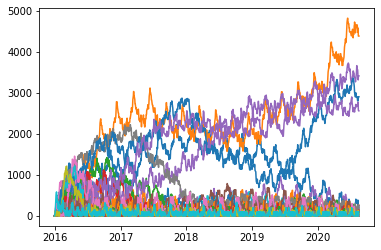

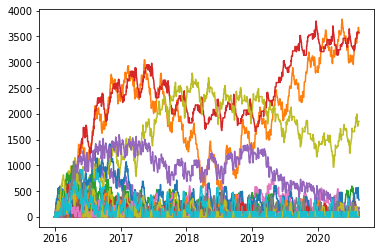

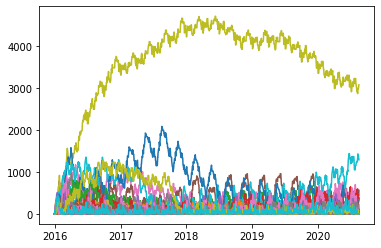

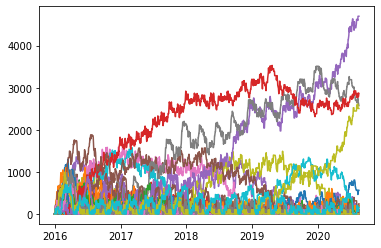

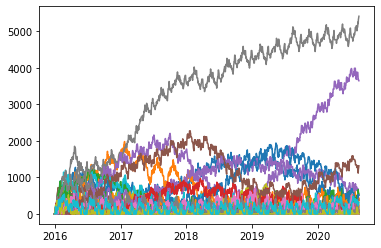

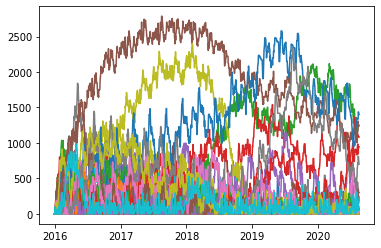

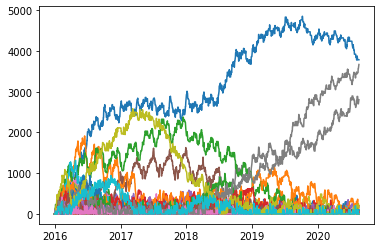

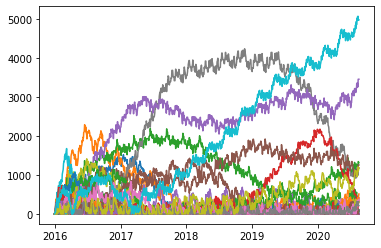

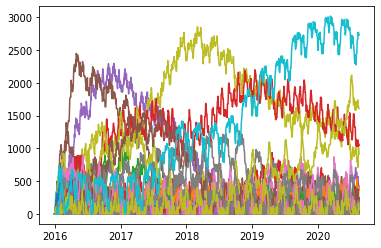

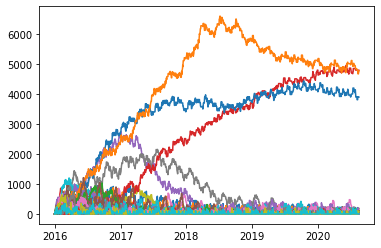

In [253]:
for seed in seeds_list:
    df = num_holdings_dict[seed]
    #df = num_holdings_dict[seed][(num_holdings_dict[seed]["datadate"]>=20160101)&
    #                             (num_holdings_dict[seed]["datadate"]<=20160130)]
    df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
    plt.plot(df["datadate"], df[ticker_names])
    plt.show()

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


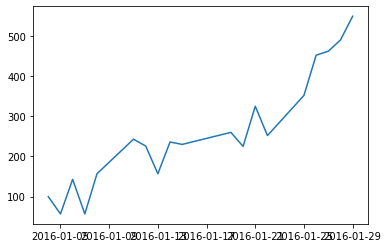

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


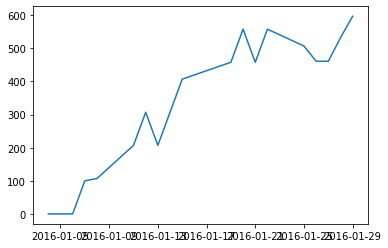

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


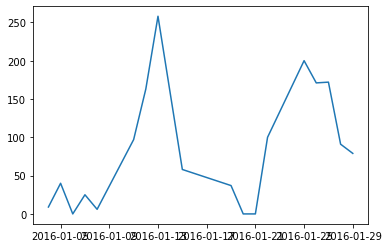

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


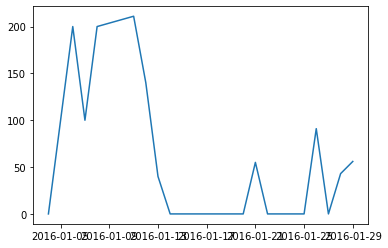

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


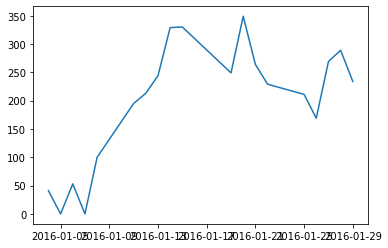

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


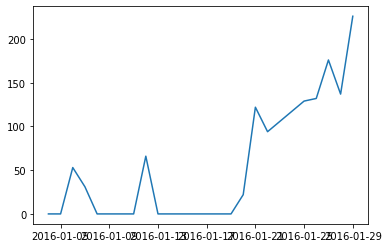

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


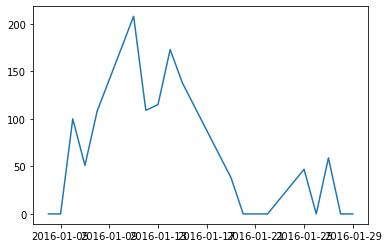

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


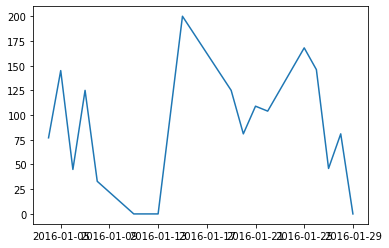

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


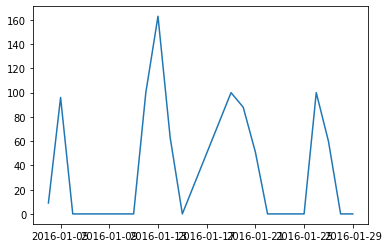

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


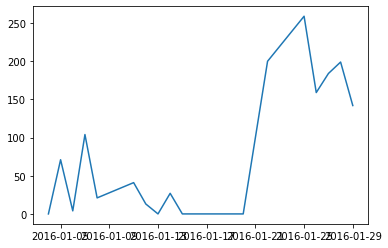

In [250]:
for seed in seeds_list:
    df = num_holdings_dict[seed][(num_holdings_dict[seed]["datadate"]>=20160101)&
                                 (num_holdings_dict[seed]["datadate"]<=20160130)]
    df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
    plt.plot(df["datadate"], df["AAPL"])
    plt.show()